In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Transfer Learning
These two major transfer learning scenarios look as follows:

**Finetuning the convnet**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

**ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [10]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

## 1. Load Data

In [48]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data_dir = './data/OFFICE31/amazon'
train_data_dir = './data/OFFICE31/dslr'

train_data = datasets.ImageFolder(os.path.join(train_data_dir), data_transforms['train'])
test_data = datasets.ImageFolder(os.path.join(train_data_dir), data_transforms['test'])

# DataLoader
train_dl = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Check Dataset Sizes
print(f"\nTrain (amazon) data size: {len(train_data)}")
print(f"\nTest (dslr) data size: {len(test_data)}")

# Class Names
train_class_names = train_data.classes
test_class_names = test_data.classes
print(f"\nTrain (amazon) class names: {train_class_names}")
print(f"\nTest (dslr) class names: {test_class_names}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Train (amazon) data size: 498

Test (dslr) data size: 498

Train (amazon) class names: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']

Test (dslr) class names: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


### 1.1. Visualize some images

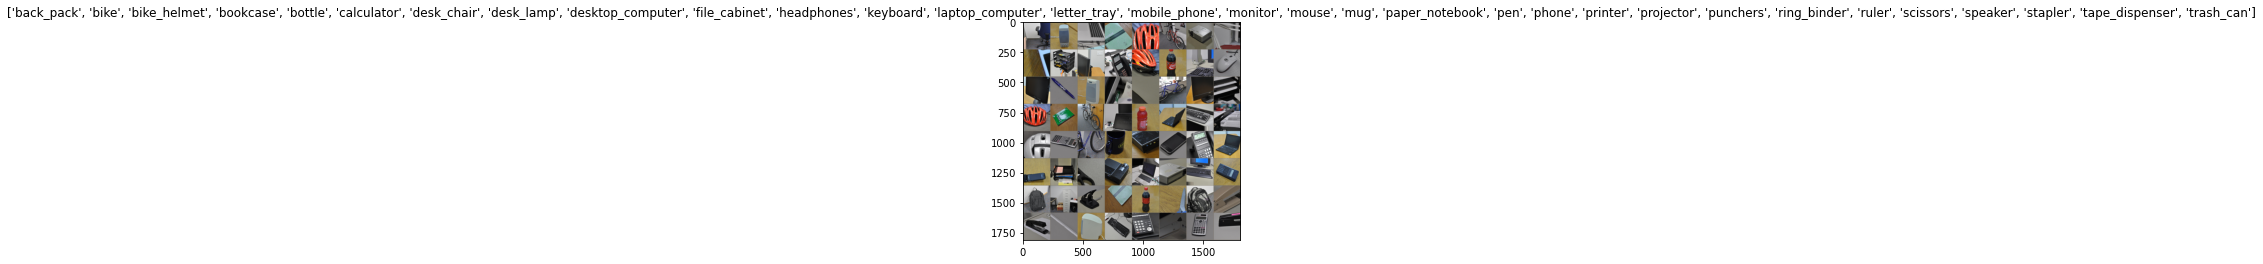

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=train_class_names)

## 2. General Functions

### 2.1. Function to train the model

In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    test_accuracy_per_epoch = []
    train_accuracy_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            # Define dataloader, size used based on current phase
            curr_dl = train_dl
            curr_size = len(train_data)
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                curr_dl = test_dl
                curr_size = len(test_data)
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in curr_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / curr_size
            epoch_acc = running_corrects.double() / curr_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' :
                test_accuracy_per_epoch.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_accuracy_per_epoch.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_accuracy_per_epoch, train_accuracy_per_epoch

### 2.2. Model Predictions Visualisation Function

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {train_class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 2.3. Plotting Helper Function

In [47]:
# Plotting Helper Function
def plot_acc_epoch(epochs, train_acc, test_acc):
    l = range(1,epochs+1)
    N = len(l)
    l2 = np.arange(N)
    plt.subplots(figsize=(10, 5))
    plt.plot(l2, test_acc, label="Testing Accuracy")
    plt.plot(l2, train_acc, label="Training Accuracy")
    plt.xticks(l2,l)
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title('Accuracy versus Epoch Transfer Learning with CovNet as Fixed Feature Extractor Model', fontsize=12)
    plt.show()

## 3. Modeling

### 3.1. Finetuning the ConvNet
First transfer learning scenario. Here, we load a pretrained model **resnet18**.

In [52]:
# Define the pretrained model: resnet18
model_ft = models.resnet18(pretrained=True)

# Define num of features
num_ftrs = model_ft.fc.in_features

# Finetune the classifier
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(train_class_names))

model_ft = model_ft.to(device)

# Define the loss function: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 3.2 Train and Evaluate the Model

In [53]:
model_ft, test_accuracy_per_epoch, train_accuracy_per_epoch = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 3.5843 Acc: 0.0462
test Loss: 3.3571 Acc: 0.1004

Epoch 1/9
----------
train Loss: 3.2263 Acc: 0.1365
test Loss: 2.8673 Acc: 0.2892

Epoch 2/9
----------
train Loss: 2.8257 Acc: 0.2972
test Loss: 2.4108 Acc: 0.4679

Epoch 3/9
----------
train Loss: 2.4360 Acc: 0.4578
test Loss: 1.9932 Acc: 0.6566

Epoch 4/9
----------
train Loss: 2.1025 Acc: 0.6265
test Loss: 1.6279 Acc: 0.7771

Epoch 5/9
----------
train Loss: 1.7871 Acc: 0.7189
test Loss: 1.3273 Acc: 0.8353

Epoch 6/9
----------
train Loss: 1.5833 Acc: 0.7932
test Loss: 1.0848 Acc: 0.8635

Epoch 7/9
----------
train Loss: 1.4478 Acc: 0.8052
test Loss: 1.0718 Acc: 0.8635

Epoch 8/9
----------
train Loss: 1.3563 Acc: 0.8233
test Loss: 1.0611 Acc: 0.8675

Epoch 9/9
----------
train Loss: 1.3710 Acc: 0.8153
test Loss: 1.0448 Acc: 0.8715

Training complete in 34m 1s
Best val Acc: 0.871486


#### 3.2.1. Plotting Accuracy vs Epoch

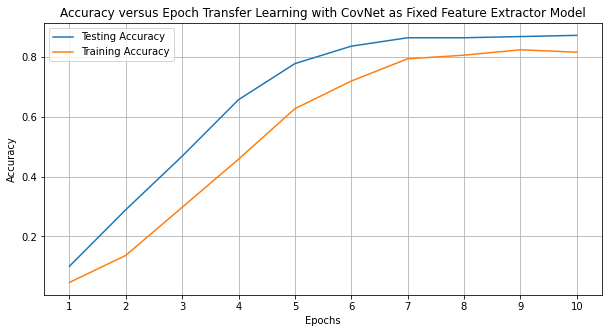

In [54]:
plot_acc_epoch(EPOCHS, train_accuracy_per_epoch, test_accuracy_per_epoch)

#### 3.2.2. Visualize resulted model

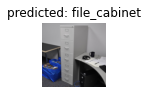

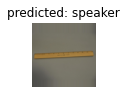

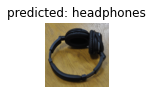

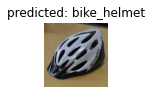

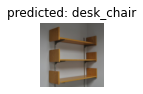

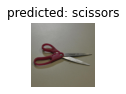

In [55]:
visualize_model(model_ft)

plt.ioff()
plt.show()